# Deep Learning &mdash; Assignment 3

Third assignment for the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:**
Daan Brugmans, Maximilian Pohl

**Group:**
31

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Experiment with convolutional neural networks
2. Train a convolutional neural network on a speech dataset
3. Investigate the effect of dropout and batch normalization
4. Define and train a residual neural network

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book,
* `python_speech_features` to compute MFCC features.

All libraries can be installed with `pip install`.

In [3]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from d2l import torch as d2l
import torch
from torch import nn
from scipy.io import wavfile

# Fix the seed, so outputs are exactly reproducible
torch.manual_seed(12345)

## 3.1 Convolution and receptive fields (9 points)

We will first define some helper functions to plot the receptive field of a node in a network.

In [4]:
def show_image(img, title=None, new_figure=True):
    if new_figure:
        plt.figure(figsize=(5, 5))
    im = plt.imshow(img, interpolation='none', aspect='equal', cmap='gray')
    ax = plt.gca();

    # plot pixel numbers and grid lines
    ax.set_xticks(np.arange(0, img.shape[1], 1))
    ax.set_yticks(np.arange(0, img.shape[0], 1))
    ax.set_xticklabels(np.arange(0, img.shape[1], 1))
    ax.set_yticklabels(np.arange(0, img.shape[0], 1))
    ax.set_xticks(np.arange(-.5, img.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, img.shape[0], 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=1.5)

    # hide axis outline
    for spine in ax.spines.values():
        spine.set_visible(False)

    if title is not None:
        plt.title(title)


# set all weights in the network to one,
# all biases to zero
def fill_weights_with_ones(network):
    for name, param in network.named_parameters():
        if 'weight' in name:
            param.data = torch.ones_like(param.data)
        elif 'bias' in name:
            param.data = torch.zeros_like(param.data)
    return network


def compute_receptive_field(network, input_size=(15, 15), binary=True):
    assert isinstance(network, torch.nn.Sequential), 'This only works with torch.nn.Sequential networks.'
    for layer in network:
        if not isinstance(layer, (torch.nn.Conv2d, torch.nn.AvgPool2d)):
            raise Exception('Sorry, this visualisation only works for Conv2d and AvgPool2d.')

    # initialize weights to ones, biases to zeros
    fill_weights_with_ones(network)

    # find the number of input and output channels
    input_channels = None
    output_channels = None
    for layer in network:
        if isinstance(layer, torch.nn.Conv2d):
            if input_channels is None:
                # first convolution layer
                input_channels = layer.in_channels
            output_channels = layer.out_channels
    if input_channels is None:
        input_channels = 1

    # first, we run the forward pass to compute the output shape give the input

    # PyTorch expects input shape [samples, channels, rows, columns]
    x = torch.zeros(1, input_channels, *input_size)
    x.requires_grad = True

    # forward pass: apply each layer in the network
    y = x
    y.retain_grad()
    ys = [y]
    for layer in network:
        y = layer(y)
        # keep track of the intermediate values so we can plot them later
        y.retain_grad()
        ys.append(y)

    # second, we run the backward pass to compute the receptive field

    # create gradient input: zeros everywhere, except for a single pixel
    y_grad = torch.zeros_like(y)
    # put a one somewhere in the middle of the output
    y_grad[0, 0, (y_grad.shape[2] - 1) // 2, (y_grad.shape[3] - 1) // 2] = 1

    # compute the gradients given this single one
    y.backward(y_grad)

    # receptive field is now in the gradient at each layer
    receptive_fields = []
    for y in ys:
        # the gradient for this layer shows us the receptive field
        receptive_field = y.grad
        if binary:
            receptive_field = receptive_field > 0
        receptive_fields.append(receptive_field)
    return receptive_fields


def plot_receptive_field(network, input_size=(15, 15), binary=True):
    receptive_fields = compute_receptive_field(network, input_size, binary)

    # plot the gradient at each layer
    plt.figure(figsize=(4 * len(receptive_fields), 4))
    for idx, receptive_field in enumerate(receptive_fields):
        plt.subplot(1, len(receptive_fields), idx + 1)
        # the last element of ys contains the output of the network
        if idx == len(receptive_fields) - 1:
            plot_title = 'output (%dx%d)' % (receptive_field.shape[2], receptive_field.shape[3])
        else:
            plot_title = 'layer %d input (%dx%d)' % (idx, receptive_field.shape[2], receptive_field.shape[3])
        # plot the image with the receptive field (sample 0, channel 0)
        show_image(receptive_field[0, 0], new_figure=False, title=plot_title)
        if not binary:
            plt.colorbar(fraction=0.047 * receptive_field.shape[0] / receptive_field.shape[1])


def receptive_field_size(network, input_size=(15, 15), binary=True):
    receptive_fields = compute_receptive_field(network, input_size, binary)
    return torch.count_nonzero(torch.flatten(receptive_fields[0][0, 0]))

Using these functions, we can define a network and plot the receptive field of a pixel in the output.

**(a) Run the code to define a network with one 3×3 convolution layer and plot the images.**

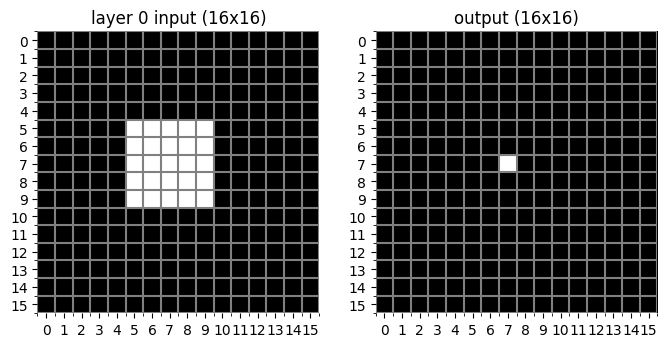

In [14]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(5, 5), stride=1, padding=2),
)
plot_receptive_field(net, input_size=(16, 16))

Read these images as follows:
* On the left, you see the input size of the network (here: 15 x 15 pixels) and the receptive field for one pixel in the output.
* On the right, you see the output size of the network (here: 13 x 13 pixels).

To visualize the receptive field of this network, we used the following procedure:
* We selected one pixel of the output (shown as the white pixel in the center in the image on the right).
* We computed the gradient for this pixel and plotted the gradient with respect to the input (the image on the left).
* This shows you the receptive field of the network: the output for the pixel we selected depends on these 9 pixels in the input.

**(b) Use this method to plot the receptive field of a pixel in the output of a convolution layer with a kernel size of 5×5.<span style="float:right"> (1 point)</span>**

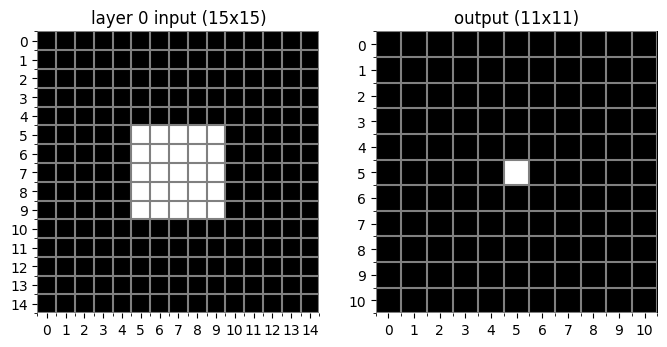

In [4]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(5, 5)),
)
plot_receptive_field(net, input_size=(15, 15))

If you look at the result, you will see that two things have changed: the receptive field and the output size.

**(c) How do the receptive field size and the output size depend on the kernel size? Give a formula.<span style="float:right"> (1 point)</span>**

receptive_field_size = input_field_size - kernel_size + 1
receptive_field_size = kernel_size

### Counting the number of parameters

In the previous question, you saw how the receptive fields of a 3x3 convolution differs from a 5x5 kernel convolution. But this is not the only difference: there is also a difference in the number of parameters in the network.

We can count the number of parameters in the network by computing the number of elements (e.g., the weights and biases in a convolution kernel) in the parameter list of the PyTorch network.

We'll define a small helper function to do this:

In [5]:
def print_parameter_count(network):
    # sum the number of elements in each parameter of the network
    count = sum([param.data.numel() for param in network.parameters()])
    print('%d parameters' % count)

**(d) Use the function to count the number of parameters for a 3x3 convolution.**

10 parameters


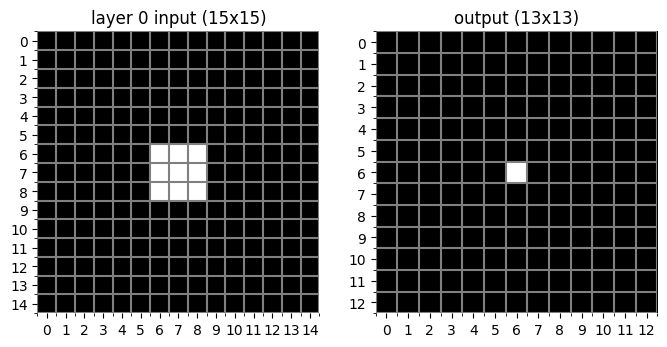

In [6]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3)),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(e) Do the same to count the number of parameters for a 5x5 convolution.<span style="float:right"> (1 point)</span>**

26 parameters


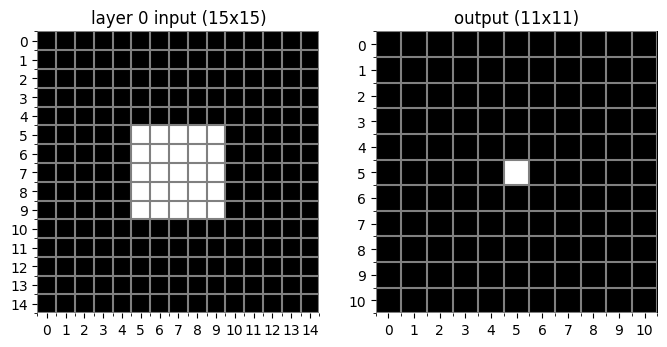

In [7]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(5, 5)),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(f) Explain the results by showing how to _compute_ the number of parameters for the 3x3 and 5x5 convolutions.<span style="float:right"> (1 point)</span>**

Number of elements in the kernel + one bias

#params_5x5 = 5 * 5 + 1
#params_3x3 = 3 * 3 + 1

For these computations we used convolution layers with one input and one output channel.

We can also compute the results for a layer with a different number of channels.

**(g) Define a network with a 5x5 convolution, 2 input channels and 3 output channels. Print the number of parameters.**

153 parameters


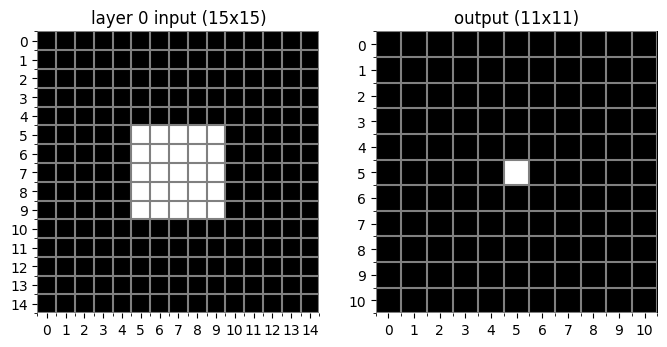

In [8]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(2, 3, kernel_size=(5, 5)),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(h) Show how to compute the number of parameters for this case.<span style="float:right"> (1 point)</span>**

input_channels * kernel_size_x * kernel_size_y * output_channels + biases (=output channels)

2 * 5 * 5 * 3 + 3 = 153

### Preserving the size of the input image

The PyTorch documentation for [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) describes the parameters that you can use to define a convolutional layer. We will explore some of those parameters in the next questions.

In the previous plot, you may have noticed that the output (13x13 pixels) was slightly smaller than the input (15x15 pixels).

**(i) Define a network with a single 3x3 convolutional layer that produces an output that has the same size as the input.<span style="float:right"> (1 point)</span>**

Use 1 input and 1 output channel.

10 parameters


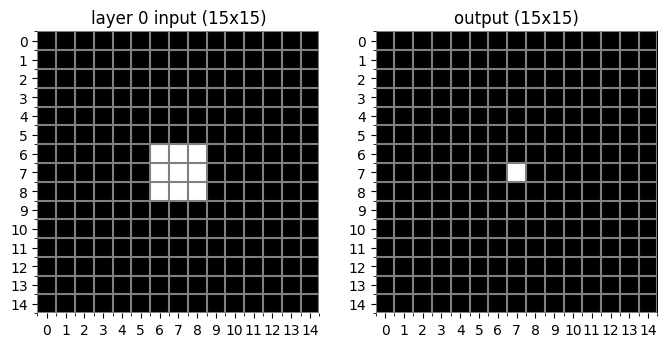

In [9]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(j) Define a network with a single 5x5 convolutional layer that preserves the input size.<span style="float:right"> (1 point)</span>**

26 parameters


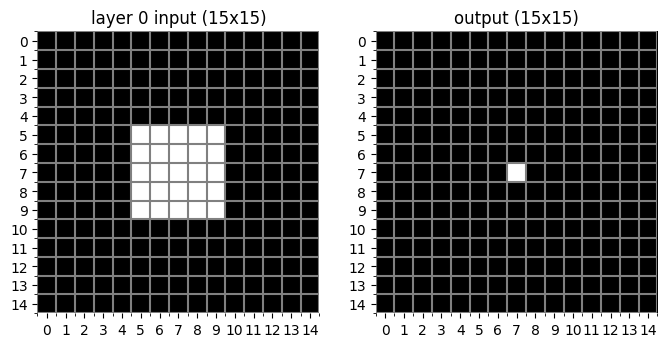

In [10]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(5, 5), padding=2),
)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

Play around with some other values to see how this parameter behaves.

### Multiple layers

As you have just seen, one way to increase the size of the receptive field is to use a larger convolution kernel. But another way is to use more than one convolution layer.

**(k) Define a network with two 3x3 convolutions, preserving the image size. Show the receptive field and the number of parameters.<span style="float:right"> (1 point)</span>**

For this visualisation, do not use any activation functions, and use 1 channel everywhere.

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
20 parameters


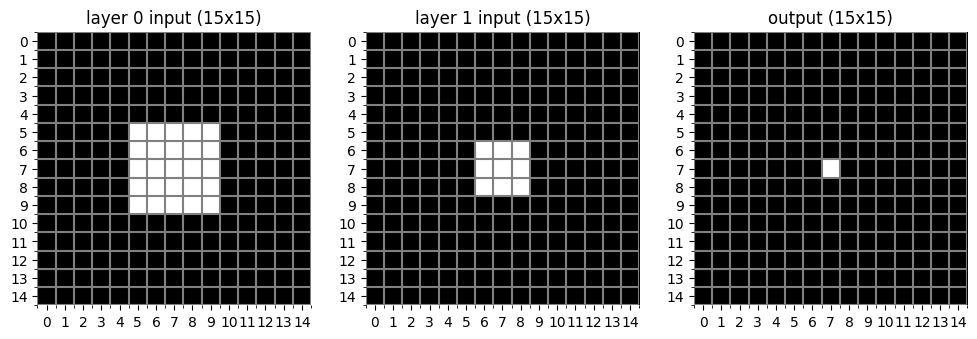

In [11]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1),
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1),
)
print(net)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

Since we now have two layers, the visualization shows an extra image. From right to left, we have:
* Right: the output size and a single active pixel.
* Middle: the receptive field for the single output pixel between the first and second convolution.
* Left: the receptive field for the single output pixel in the input image.

We have now tried two ways to increase the receptive field size: increasing the kernel size, and using multiple layers.

**(l) Compare the number of parameters required by the two options. Which one is more parameter-efficient?<span style="float:right"> (1 point)</span>**

One 5x5 convolution requires 26 parameters, while two 3x3 convolutions, resulting in the same receptive field, only require 20 parameters. This means, applying two 3x3 convolutions is more parameter efficient than one 5x5 convolution.

## 3.2 Variations on convolution (8 points)

### Pooling

We can also increase the size of the receptive field by using a pooling layer.

**(a) Construct a network with a 3x3 convolution (preserving the input size) followed by a 2x2 average pooling. Plot the receptive field and print the number of parameters.<span style="float:right"> (1 point)</span>**

Use 1 input and 1 output channel.

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
)
10 parameters


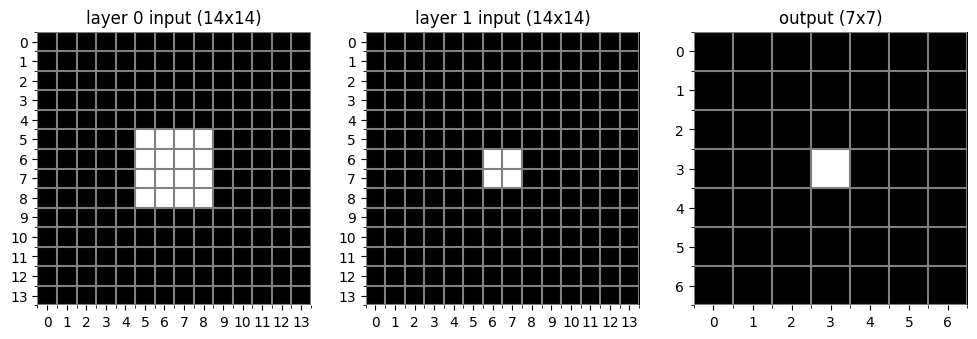

In [12]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1),
    nn.AvgPool2d(2)
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)

**(b) Explain the number of parameters in this convolution + pooling network.<span style="float:right"> (1 point)</span>**

The pooling layer does not have any parameters, thus we are left with the 10 params from the 3x3 convolution.

### Dilation

A third option to increase the receptive field is _dilation_.

**(c) Define a network with 3x3 convolution with dilation that preserves the input size.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
)
10 parameters


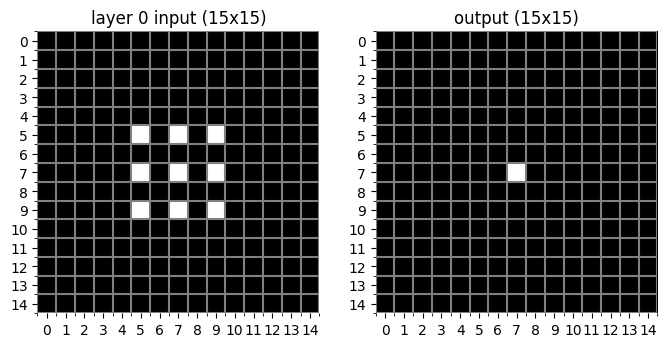

In [13]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=2, dilation=2)
)
# the output should also be 15x15 pixels
print(net)
plot_receptive_field(net, input_size=(15, 15))
print_parameter_count(net)

**(d) Explain how dilation affects the receptive field.<span style="float:right"> (1 point)</span>**

The dilation spreads out the pixels we use for our input, making the receptive field bigger but less dense.

### Using strides

By default, convolution layers use a stride of 1.

**(e) Change the network to use a stride of 2 and plot the result.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)
10 parameters


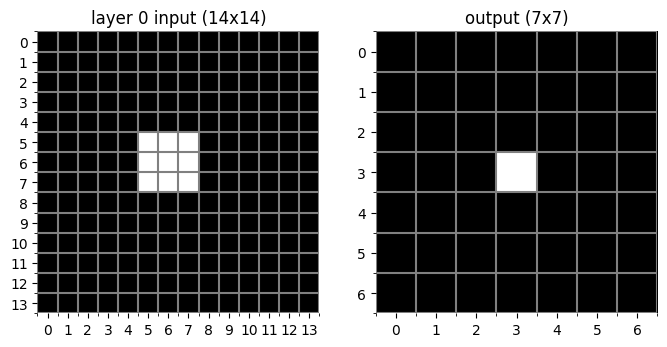

In [14]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=(1, 1), stride=2),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)

**(f) Explain the new output size and compare the result with that of pooling.<span style="float:right"> (1 point)</span>**

As we now move by 2 pixels for each iteration, the number of output pixels halves. The pooling results in the same output size, but has a bigger input by one pixel.

**(g) Explain how the stride affects the receptive field of this single convolution layer.<span style="float:right"> (1 point)</span>**

The size of the receptive field stays the same, but there is less, i.e., only half the number of different receptive fields. There is less overlap in the inputs for the different output pixels.

**(h) Explain the number of parameters for this network.<span style="float:right"> (1 point)</span>**

The number of parameters stays the same, as there is still a 3x3 kernel + one bias resulting in ten params.

## 3.3 Combining layers (7 points)

As you have seen, there are multiple ways to increase the receptive field. You can make interesting combinations by stacking multiple layers.

Let's try a few ways to make networks with a large receptive field. For each of the questions in this section:

* Create a network where a pixel in the output has a 9x9 receptive field.
* Use 3 input channels and 3 output channels in every layer.
* In convolution layers, try to preserve the input size as much as possible.

**(a) Make a network with a single convolution that satisfies the above conditions.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
)
732 parameters


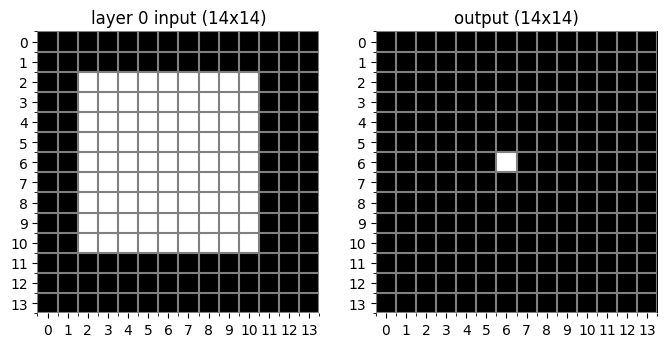

In [15]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 3, kernel_size=(9, 9), padding=(4, 4)),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)
assert receptive_field_size(net) == 9 * 9, "Receptive field of output pixel should be a 9x9 square"

Many popular network architectures use a sequence of 3x3 convolutions.

**(b) Use only 3x3 convolutions.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
336 parameters


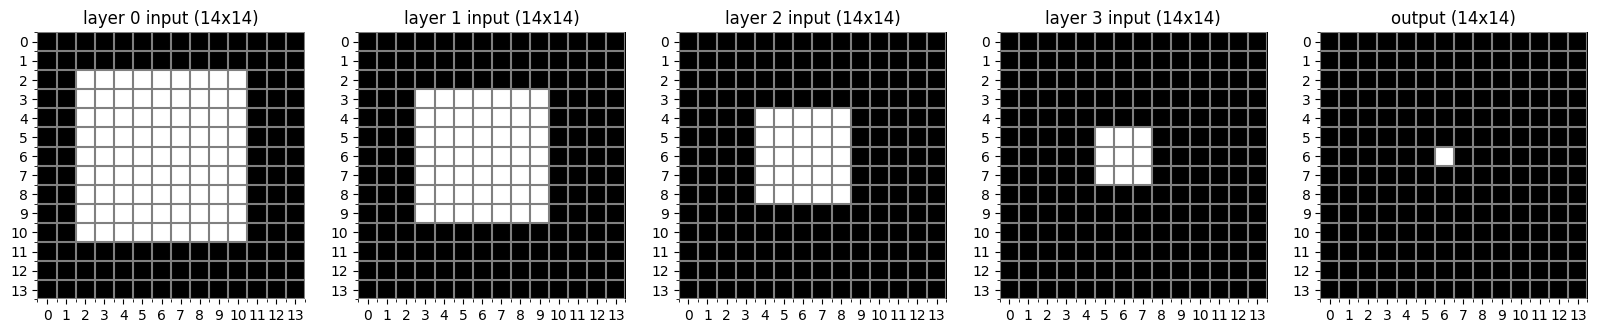

In [16]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 3, kernel_size=(3, 3), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(3, 3), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(3, 3), padding=(1, 1)),
    torch.nn.Conv2d(3, 3, kernel_size=(3, 3), padding=(1, 1)),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)
assert receptive_field_size(net) == 9 * 9, "Receptive field of output pixel should be a 9x9 square"

**(c) Use a 2x2 average pooling layer in combination with one or more 3x3 convolutions.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
231 parameters


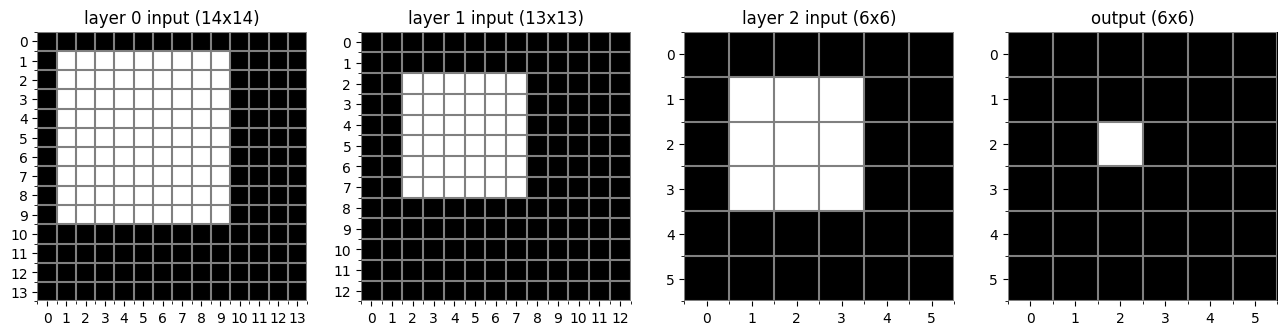

In [17]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 3, kernel_size=4, padding=1),
    torch.nn.AvgPool2d(2),
    torch.nn.Conv2d(3, 3, kernel_size=3, padding=1),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)
assert receptive_field_size(net) == 9 * 9, "Receptive field of output pixel should be a 9x9 square"

**(d) Copy the previous convolution + pooling network and replace the pooling layer with a strided convolution layer.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(3, 3), padding=(10, 10))
  (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(8, 8))
)
168 parameters


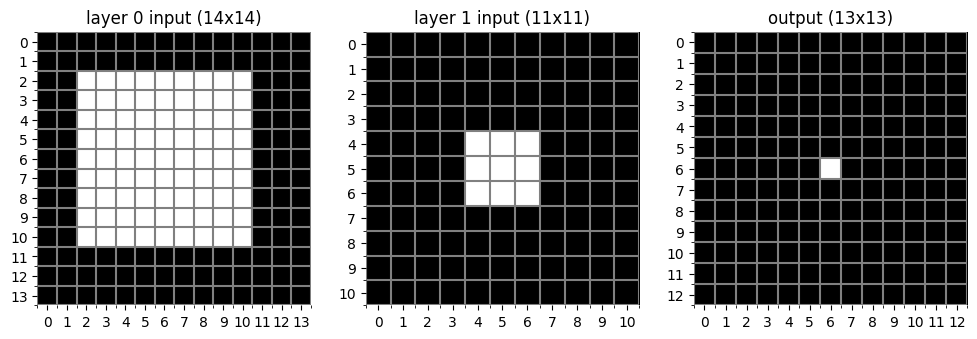

In [18]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 3, kernel_size=3, padding=10, stride=3),
    torch.nn.Conv2d(3, 3, kernel_size=3, padding=8, stride=2),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)
assert receptive_field_size(net) == 9 * 9, "Receptive field of output pixel should be a 9x9 square"

**(e) Construct a network with exactly two 3x3 convolutions. Use dilation to get a receptive field of 9x9 pixels.<span style="float:right"> (1 point)</span>**

Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
)
168 parameters


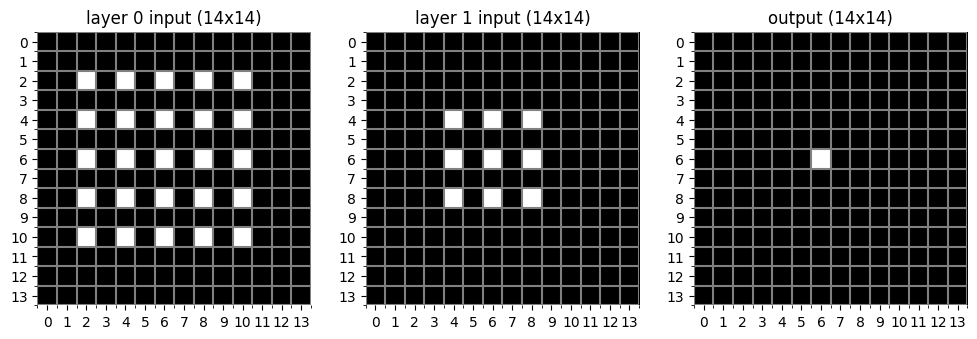

In [19]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 3, kernel_size=3, padding=2, dilation=2),
    torch.nn.Conv2d(3, 3, kernel_size=3, padding=2, dilation=2),
)
print(net)
plot_receptive_field(net, input_size=(14, 14))
print_parameter_count(net)
# assert receptive_field_size(net) == 9 * 9, "Receptive field of output pixel should be a 9x9 square"

**(f) For each of the methods, list the number of layers, the number of parameters, and the size of the output of the network:**

| Method                   | Layers | Parameters | Output size |
|--------------------------|--------|------------|-------------|
| One 9x9 convolution      | 1      | 732        | 14x14       | 
| Many 3x3 convolutions    | 4      | 336        | 14x14       |
| With pooling             | 3      | 231        | 6x6         |
| With strided convolution | 2      | 168        | 13x13       |
| With dilation            | 2      | 168        | 14x14       |

**(g) Compare the methods in terms of the number of parameters.<span style="float:right"> (1 point)</span>**

- The smaller the convolution kernel is, the smaller the number of parameters
- Even multiple small convolutions result in fewer parameters than one big
- Using pooling additionally reduces the number of parameters
- Using dilation or stride, instead of pooling, the number of parameters resources even more.

**(h) Compare the methods in terms of the output size. How much downsampling do they do?<span style="float:right"> (1 point)</span>**

Only the method with pooling reduces the output size significant, from 14x14 to 6x6. The other methods compensate for the reduction by padding, which also influences how good the information on the edges are, but does not reduce the output size (by a lot).

## 3.4 Padding in very deep networks (2 points)

Without padding, the output of a convolution is smaller than the input. This limits the depth of your network.

**(a) How often can you apply a 3x3 convolution to a 15x15 input image?**

In [20]:
# find the maximum number of layers
infinity = 25

# create a 15x15 input
x = torch.zeros(1, 1, 15, 15)
print('input size: %dx%d' % (x.shape[2], x.shape[3]))

# create a 3x3 convolution
conv = torch.nn.Conv2d(1, 1, kernel_size=(3, 3))

# for n in range(infinity):
#     # apply another convolution
#     x = conv(x)
#     print('layer %d, output size: %dx%d' % (n + 1, x.shape[2], x.shape[3]))

input size: 15x15


Earlier in this assignment, you have used padding to address this problem. This seems ideal.

**(b) Copy the previous code, add some padding, and show that we can now have an infinite number of layers.**

(We are computer scientists and not mathematicians, so for the purpose of this question we'll consider 'infinite' to be equal to 25.)

In [21]:
# find the maximum number of layers
infinity = 25

# create a 15x15 input
x = torch.zeros(1, 1, 15, 15)
print('input size: %dx%d' % (x.shape[2], x.shape[3]))

# create a 3x3 convolution
conv = torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=1)

for n in range(infinity):
    # apply another convolution
    x = conv(x)
    print('layer %d, output size: %dx%d' % (n + 1, x.shape[2], x.shape[3]))

input size: 15x15
layer 1, output size: 15x15
layer 2, output size: 15x15
layer 3, output size: 15x15
layer 4, output size: 15x15
layer 5, output size: 15x15
layer 6, output size: 15x15
layer 7, output size: 15x15
layer 8, output size: 15x15
layer 9, output size: 15x15
layer 10, output size: 15x15
layer 11, output size: 15x15
layer 12, output size: 15x15
layer 13, output size: 15x15
layer 14, output size: 15x15
layer 15, output size: 15x15
layer 16, output size: 15x15
layer 17, output size: 15x15
layer 18, output size: 15x15
layer 19, output size: 15x15
layer 20, output size: 15x15
layer 21, output size: 15x15
layer 22, output size: 15x15
layer 23, output size: 15x15
layer 24, output size: 15x15
layer 25, output size: 15x15


**(c) Does it really work like this? Have a look at the following experiment.**

* We simulate a convolution network with 25 convolution layers, with 3x3 kernels and the right amount of padding.
* We set the weights to 1/9 (so that the sum of the 3x3 kernel is equal to 1) and set the bias to zero.
* We give this network a 15x15-pixel input filled with ones.
* We plot the output of layers 5, 10, 15, 20, and 25.

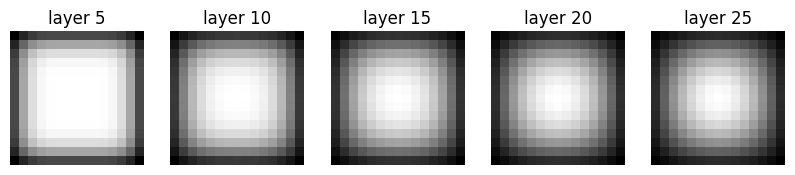

In [22]:
# create a 15x15 input filled with ones
x = torch.ones(1, 1, 15, 15)

# create a 3x3 convolution
conv = torch.nn.Conv2d(1, 1, kernel_size=(3, 3), padding=(1, 1))

# set weights to 1/9 (= sum to one), bias to zero
conv.weight.data = torch.ones_like(conv.weight.data) / 9
conv.bias.data = torch.zeros_like(conv.bias.data)

plt.figure(figsize=(10, 2))
for n in range(1, 26):
    # apply another convolution
    x = conv(x)
    # print('layer %d, output size: %dx%d' % (n + 1, x.shape[2], x.shape[3]))
    if n % 5 == 0:
        plt.subplot(1, 5, n // 5)
        plt.imshow(x[0, 0].detach().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('layer %d' % n)

**(d) Explain the pattern that we see in the output of the final layers. How does this happen, and what does this mean for our very deep networks?<span style="float:right"> (2 points)</span>**

The deeper the network gets, the more black borders we have at the edges. This happens because we continuously pad zeros to the outside, which get seeped more into the middle of the image by the kernel.

For deep networks, this means that they could only properly recognize objects that are not on the edge of the iamge. 

## 3.5 Spoken digits dataset (4 points)

Time for some practical experiments. The d2l book uses a dataset of images as a running example (FashionMNIST). In this assignment we will investigate CNNs in a completely different domain: speech recognition.

The dataset we use is the free spoken digits dataset, which can be found on https://github.com/Jakobovski/free-spoken-digit-dataset. This dataset consists of the digits 0 to 9, spoken by different speakers. The data comes as .wav files.

**(a) Use the commands below (or a similar tool) to download the dataset. You can also use `git clone` to clone the repository mentioned above.**

In [23]:
#! mkdir -p free-spoken-digit-dataset
#! wget -O - https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.tar.gz | tar xzv -C free-spoken-digit-dataset --strip-components=1

Below is a function to load the data. We pad/truncate each sample to the same length.
The raw audio is usually stored in 16 bit integers, with a range -32768 to 32767, where 0 represents no signal. Before using the data, it should be normalized. A common approach is to make sure that the data is between 0 and 1, between -1 and 1, or zero-mean unit-variance.  Not all of these work well on this data, so later on, if your
network doesn't seem to learn anything: try a different method to see if that works better.

**(b) Update the below code to normalize the data to a reasonable range.<span style="float:right"> (1 point)</span>**

In [24]:
samplerate = 8000


def load_waveform(file, size=6000):
    samplerate, waveform = wavfile.read(file)
    # Take first 6000 samples from waveform. With a samplerate of 8000 that corresponds to 3/4 second
    # Pad with 0s if the file is shorter
    waveform = np.pad(waveform, (0, size))[0:size]
    # Normalize waveform
    waveform = (waveform - np.mean(waveform)).astype(int)
    waveform = (waveform / np.std(waveform)).astype(int)
    return waveform

The following code loads all .wav files in a directory, and makes it available in a pytorch dataset.

**(c) Load the data into a variable `data`.**

In [25]:
class SpokenDigits(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        digits_x = []
        digits_y = []
        for file in os.listdir(data_dir):
            if file.endswith(".wav"):
                waveform = load_waveform(os.path.join(data_dir, file))
                label = int(file[0])
                digits_x.append(waveform)
                digits_y.append(label)
        # convert to torch tensors
        self.x = torch.from_numpy(np.array(digits_x, dtype=np.float32))
        # add an extra dimension to represent the "channels" (we start with 1 channel of data)
        self.x = self.x.unsqueeze(1)
        self.y = torch.from_numpy(np.array(digits_y))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


data = SpokenDigits(os.path.join(os.getcwd(), "free-spoken-digit-dataset", "recordings"))

**(d) Describe the dataset: how many samples are there, how many features does each sample have? How many classes are there?<span style="float:right"> (1 point)</span>**

In [26]:
print(f"There are {len(data)} samples and {data[0][0].shape[1]} features per sample and ten classes")

There are 3000 samples and 6000 features per sample and ten classes


Here is code to play samples from the dataset to give you an idea what it "looks" like.

Note: If this step doesn't work in your notebook, then you can ignore it.

In [27]:
from IPython.display import Audio


def play(sample):
    print(f'Label: {sample[1]}')
    return Audio(sample[0][0].numpy(), rate=samplerate)


play(data[0])

Label: 6


Before continuing, we split the dataset into a training and a test set.

In [28]:
train_prop = 2 / 3
train_count = int(len(data) * train_prop)
train, test = torch.utils.data.random_split(data, [train_count, len(data) - train_count])

The code above uses 2/3 of the data for training.

**(e) Discuss an advantage and disadvantage of using more of the data for training.<span style="float:right"> (2 points)</span>**

- The more different training data you use, the more you reduce the change of overfitting.
- The more training data you have, the more accurate your network can become.
----
- Using more data for training, results in less data for validation, which increases the chance of not representing the real-world data properly.

Finally, we split the data into batches:

In [29]:
data_params = {'batch_size': 32}
train_iter = torch.utils.data.DataLoader(train, **data_params)
test_iter = torch.utils.data.DataLoader(test, **data_params)

## 3.6 One-dimensional convolutional neural network (8 points)

11872We will now define a network architecture. We will use a combination of convolutional layers and pooling.
Note that we use 1d convolution and pooling here, instead of the 2d operations used for images.

**(a) Complete the network architecture, look at the d2l book [chapter 7](http://d2l.ai/chapter_convolutional-neural-networks/index.html) and [chapter 8](http://d2l.ai/chapter_convolutional-modern/index.html) for examples.<span style="float:right"> (2 points)</span>**

In [30]:
def build_net():
    return torch.nn.Sequential(
        nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Flatten(),
        nn.Linear(11872, 128), nn.ReLU(),
        nn.Linear(128, 64), nn.ReLU(),
        nn.Linear(64, 10))

**(b) The first fully connected layer has input dimension 11872, where does that number come from?<span style="float:right"> (1 point)</span>**

In [31]:
features = 6000
for i in range(4):
    features -= 4  # Each convolution reduces the number of features by 4
    features //= 2  # Each avg pooling halves the number of features
features * 32  # multiply the features per channel with the number of channels

11872

Hint: think about how (valid) convolutional layers and pooling layers with stride affect the size of the data.

**(c) How many parameters are there in the model? I.e. the total number of weights and biases.<span style="float:right"> (1 point)</span>**

In [32]:
print_parameter_count(build_net())

1532090 parameters


**(d) Suppose that instead of using convolutions, we had used only fully connected layers, while keeping the number of features on each hidden layer the same. How many parameters would be needed in that case approximately?<span style="float:right"> (1 point)</span>**

In [33]:
(6000 ** 2 + 6000) * 4

144024000

We would have about a 150 million params if we used four fully connected layers.

The FashionMNIST dataset used in the book has 60000 training examples. How large is our training set? How would the difference affect the number of epochs that we need? Compare to [chapter 7.6](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html) and [chapter 8.1](http://d2l.ai/chapter_convolutional-modern/alexnet.html) of the book.

**(e) How many epochs do you think are needed?<span style="float:right"> (1 point)</span>**

In [34]:
lr, num_epochs = 0.01, 30

We will use the code from (a previous edition of) the d2l book to train the network.
In particular, the `train` function, defined in [chapter 7.6](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html#training). This function is reproduced below:

In [35]:
def train(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device, torch.long)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

**(f) Now train the network.**

loss 0.000, train acc 1.000, test acc 0.437
4917.4 examples/sec on cuda:0


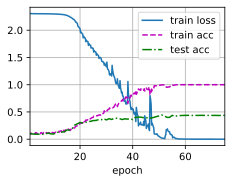

In [36]:
train(build_net(), train_iter, test_iter, num_epochs=75, lr=0.02)

**(g) Did the training converge?<span style="float:right"> (2 point)</span>**

**If the training has not converged, maybe you need to change the number of epochs and/or the learning rate.**

Hint: This is a non-trivial problem, so your network might take some time to
learn. Don't give up too quickly, it might take 50-100 epochs before you
see any significant changes in the loss curves.


| Experiment   | epochs | lr   | train accuracy | test accuracy | converged? |
|--------------|--------|------|----------------|---------------|------------|
| experiment 1 | 75     | 0.02 | 1              | 0.438         | yes        |
| experiment 2 | 150    | 0.02 | 1              | 0.647         | yes        |

## 3.7 Questions and evaluation (6 points)

**(a) Does the network look like it is overfitting or underfitting? Explain how see this.<span style="float:right"> (1 point)</span>**

The network does not underfit. We do not see any signs of overfitting either, but we cannot be completely sure, as we don't see the training loss.

**(b) Is what we have here a good classifier? Could it be used in a realistic application? Motivate your answer.<span style="float:right"> (1 point)</span>**

No, this model could not be used in a real would application. Users would be annoyed too much by the network that only understands the numbers right in about 50% of the cases.

**(c) Do you think there is enough training data compared to the dimensions of the data and the number of parameters? Motivate your answer.<span style="float:right"> (1 point)</span>**

No, it does not seem like that. Compared to the image classification of last exercise, we do have 15 times more network params but only twice as many training samples. Additionally, we have about 7.5 times more features per sample.

The network has way too many features and parameters compared to the size of the training set.

**(d) How could the classifier be improved? Give at least 2 suggestions.<span style="float:right"> (1 point)</span>**

1. More training data
2. Tuning the network architecture
3. Augmented training data

**(e) The free spoken digits datasets has recordings from several different speakers. Is the test set accuracy a good measure of how well the trained network would perform for recognizing digits spoken by a new, unknown speaker? And if not, how could that be tested instead?<span style="float:right"> (2 points)</span>**

Yes, it would be a good approach, as the network would be confronted with a new person it never heard before, which makes sense if we want to have an independent test set.

## 3.8 Variations (8 points)

One way in which the training might be improved is with dropout or with batch normalization.

**(a) Make a copy of the network architecture from 3.6a below, and add dropout.<span style="float:right"> (1 point)</span>**

Hint: see [chapter 8.1](http://d2l.ai/chapter_convolutional-modern/alexnet.html#architecture) for an example that uses dropout.

loss 0.134, train acc 0.957, test acc 0.651
5162.4 examples/sec on cuda:0


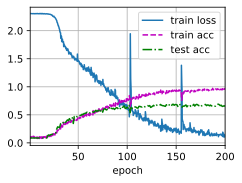

In [37]:
def build_net_dropout():
    return torch.nn.Sequential(
        nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Flatten(),
        nn.Linear(11872, 128), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(64, 10))


train(build_net_dropout(), train_iter, test_iter, num_epochs=200, lr=0.02)

**(b) How does dropout change the results? Does this match what you saw on the simple network last week?<span style="float:right"> (1 point)</span>**

- The training loss does not go down that quickly and does not reach 0.
- The training acc does not reach 1 and also does not increase as quickly.

**(c) Make a copy of the original network architecture, and add batch normalization to all convolutional and linear layers.<span style="float:right"> (1 point)</span>**

Hint: see [chapter 8.5](http://d2l.ai/chapter_convolutional-modern/batch-norm.html#concise-implementation) for an example.

loss 0.016, train acc 1.000, test acc 0.738
4317.1 examples/sec on cuda:0


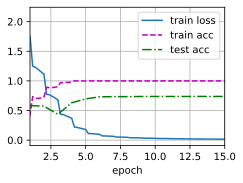

In [38]:
def build_net_batchnorm():
    return torch.nn.Sequential(
        nn.Conv1d(1, 4, kernel_size=5), nn.LazyBatchNorm1d(), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(4, 8, kernel_size=5), nn.LazyBatchNorm1d(), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(8, 16, kernel_size=5), nn.LazyBatchNorm1d(), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Conv1d(16, 32, kernel_size=5), nn.LazyBatchNorm1d(), nn.ReLU(),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Flatten(),
        nn.Linear(11872, 128), nn.LazyBatchNorm1d(), nn.ReLU(),
        nn.Linear(128, 64), nn.LazyBatchNorm1d(), nn.ReLU(),
        nn.Linear(64, 10))


train(build_net_batchnorm(), train_iter, test_iter, num_epochs=15, lr=0.02)

**(d) How does batch normalization change the results? Does this match what you saw on the simple network last week?<span style="float:right"> (1 point)</span>**

The training converges a lot faster and the training loss, as well as the test accuracy are much better.

The improvement is much bigger than on the simple network of last week.

### Residual network

We can also try to use a residual network. The book has code for a 2d resnet in [Chapter 8.6](http://d2l.ai/chapter_convolutional-modern/resnet.html).

**(e) Copy the `Residual` module here, and adapt it for 1d convolutions. Use a kernel size of 5 for the convolution layers.<span style="float:right"> (2 points)</span>**

Use residual blocks each containing two convolutional layers.

In [39]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""

    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv1d(num_channels, kernel_size=5, padding=2,
                                   stride=strides)
        self.conv2 = nn.LazyConv1d(num_channels, kernel_size=5, padding=2)

        if use_1x1conv:
            self.conv3 = nn.LazyConv1d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.LazyBatchNorm1d()
        self.bn2 = nn.LazyBatchNorm1d()

    def forward(self, X):
        Y = nn.functional.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return nn.functional.relu(Y)

**(f) Make a copy of the network architecture from 3.6a, and replace the convolutions with residual blocks.<span style="float:right"> (1 point)</span>**

loss 0.004, train acc 1.000, test acc 0.865
2888.8 examples/sec on cuda:0


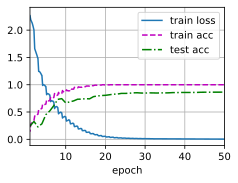

In [40]:
def build_resnet():
    return torch.nn.Sequential(
        Residual(4, use_1x1conv=True),
        nn.AvgPool1d(kernel_size=2, stride=2),

        Residual(8, use_1x1conv=True),
        nn.AvgPool1d(kernel_size=2, stride=2),

        Residual(16, use_1x1conv=True),
        nn.AvgPool1d(kernel_size=2, stride=2),

        Residual(32, use_1x1conv=True),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Flatten(),
        nn.Linear(12000, 128), nn.ReLU(),
        nn.Linear(128, 64), nn.ReLU(),
        nn.Linear(64, 10))


train(build_resnet(), train_iter, test_iter, num_epochs=50, lr=0.01)

**(g) How do residual connections change the results?<span style="float:right"> (1 point)</span>**

Using the residual connections slows down the convergence speed, but significantly improves the train loss, and the train and test accuracy. By now, we have a test accuracy of nearly 90%.

## 3.9 Feature extraction (5 points)

Given enough training data a deep neural network can learn to extract features from raw data like audio and images. However, in some cases it is still necessary to do manual feature extraction, in particular when working with smaller datasets like this one. For speech recognition, a popular class of features are [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).

Here is code to extract these features. You will need to install the `python_speech_features` first.

In [41]:
from python_speech_features import mfcc


def load_waveform_mfcc(file, size=6000):
    samplerate, waveform = wavfile.read(file)
    waveform = np.pad(waveform, (0, size))[0:size] / 32768
    return np.transpose(mfcc(waveform, samplerate))

**(a) Implement a variation of the dataset that uses these features.<span style="float:right"> (2 points)</span>**

In [42]:
class SpokenDigitsMFCC(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.spoken_digits = SpokenDigits(data_dir)

    def __len__(self):
        return len(self.spoken_digits)

    def __getitem__(self, item):
        return mfcc(self.spoken_digits[item][0], samplerate), self.spoken_digits[item][1]


data_mfcc = SpokenDigitsMFCC(os.path.join(os.getcwd(), "free-spoken-digit-dataset", "recordings"))
train_count_mfcc = int(len(data_mfcc) * train_prop)
train_mfcc, test_mfcc = torch.utils.data.random_split(data_mfcc, [train_count_mfcc, len(data_mfcc) - train_count_mfcc])
train_iter_mfcc = torch.utils.data.DataLoader(train_mfcc, **data_params)
test_iter_mfcc = torch.utils.data.DataLoader(test_mfcc, **data_params)

# TODO check if this assert is correct
# assert next(iter(train_iter_mfcc))[0].shape == torch.Size(
#     [data_params['batch_size'], 13, 74]), "There is something wrong with the SpokenDigitsMFCC dataset"

The MFCC features will have 13 channels instead of 1 (the `unsqueeze` operation is not needed). 

**(b) Inspect the shape of the data, and define a new network architecture that accepts data with this shape.<span style="float:right"> (1 point)</span>**

In [43]:
def build_net_mfcc():
    return torch.nn.Sequential(
        Residual(16, use_1x1conv=True),
        nn.AvgPool1d(kernel_size=2, stride=2),

        Residual(32, use_1x1conv=True),
        nn.AvgPool1d(kernel_size=2, stride=2),

        nn.Flatten(),
        nn.Linear(48000, 128), nn.ReLU(),
        nn.Linear(128, 64), nn.ReLU(),
        nn.Linear(64, 10))

**(c) Train the network with the MFCC features.<span style="float:right"> (1 point)</span>**

loss 0.005, train acc 1.000, test acc 0.689
2079.9 examples/sec on cuda:0


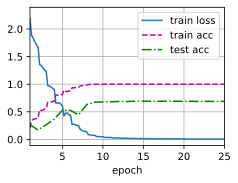

In [44]:
train(build_net_mfcc(), train_iter, test_iter, num_epochs=25, lr=0.01)

**(d) What would be needed to get a fully neural network approach to work as well as MFCC features?<span style="float:right"> (1 point)</span>**

If we had a lot more data to train on and a complex enough network, the network might learn the same or a similar approach as the MFCC.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 57 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 6717cb8 / 2023-09-15</span>